In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Image Compression and Removing Noise from Images Using Autoencoders

In this post, we will try to code a class of neural networks known as autoencoders,which have gained traction in recent years. In particular, the ability of autoencoders to image compression,removing noise from images has been greatly studied. We will build and train an autoencoder that is able compress images, denoise and restore corrupted images.

We'll look at following topics:

 - What are autoencoders?
 - Types of autoencoders — basic autoencoders, deep autoencoders and convolutional autoencoders
 - Autoencoders for image compression
 - Autoencoders for image denoising
 - Step-by-step guide to build and train an autoencoder in Keras
Analysis of our results

## What are autoencoders?

Autoencoders represent a paradigm shift from the conventional neural networks. The goal of autoencoders is to learn a `Latent Representation` of the input. This representation is usually a compressed representation of the original input.  

All autoencoders have an `Encoder` and a `Decoder`. The role of the encoder is to encode the input to a learned, compressed representation, and the role of the decoder is to reconstruct the original input using the compressed representation.

Tyical architecture of a typical autoencoder:

<img src = '/content/typ.autoencoder.png'>


Notice that, in the preceding diagram, we do not require a `label y`, unlike in CNNs. This distinction means that autoencoders are a form of `unsupervised learning`, while CNNs fall in supervised learning.


## Latent representation

You might wonder what is the purpose of autoencoders. Why do we bother learning a representation of the original input, only to reconstruct a similar output?.  
The answer lies in the learned representation of the input. By forcing the learned representation to be compressed (that is, having smaller dimensions compared to the input), we essentially force the neural network to learn the most salient representation of the input. This ensures that the learned representation only captures the most relevant characteristics of the input, known as the `latent representation`.

With this latent representation learned by the autoencoder, we can then do the following:

 - Reduce the dimensionality of the input data. The latent representation is a natural reduced representation of the input data.
 - Remove any noise from the input data (known as denoising)Noise is not a salient characteristic and therefore should be easily identifiable by using the latent representation.

### Autoencoders for data compression
Now we know how autoencoders are able to learn a reduced representation of the input data. It is natural to think that autoencoders can do a good job at generalized data compression. However, that is not the case. Autoencoders are poor at generalized data compression, such as image compression (that is, JPEG) and audio compression (that is, MP3), because the learned latent representation only represents the data on which it was trained. In other words, autoencoders only work well for images similar to those on which it was trained. 

Furthermore, autoencoders are a `lossy` form of data compression, which means that the output from autoencoders will have less information when compared to the original input. These characteristics mean that autoencoders are poor at being generalized data compression techniques. Other forms of data compression, such as JPEG and MP3, are superior when compared to autoencoders.

#### Lets first try to use the MNIST handwritten digits dataset.
The MNIST dataset contains 70,000 samples of handwritten digits, each of size 28 x 28 pixels. Each sample contains only one digit within the image, and all samples are labeled.


In [2]:
from keras.datasets import mnist

(X_train,y_train), (X_test,y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


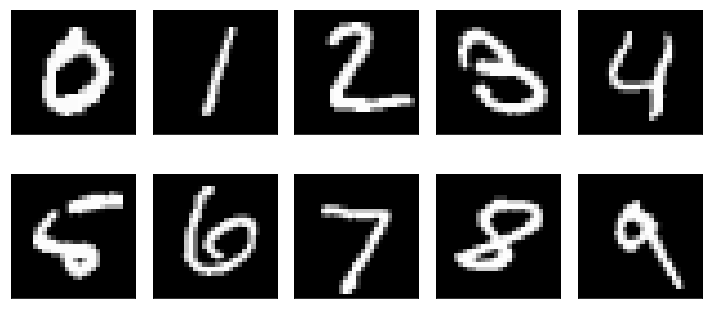

In [3]:
#Let's plot out each of the digits to better visualize our data

from matplotlib import pyplot as plt
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(10,5))

for idx, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    for i in range(1000):
        if y_test[i] == idx:
            ax.imshow(X_test[i], cmap='gray')
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            break
plt.tight_layout()
plt.show()

We can see that the digits are handwritten, and each 28 x 28 image captures only one digit. The autoencoder should be able to learn the compressed representation of these digits (smaller than 28 x 28), and to reproduce the images using this compressed representation.

<img src = '/content/dig-autoencoder.png'>

## Building autoencoder for image compression in Keras

let's start off by building the most basic autoencoder, as shown in the following diagram:

<img src = '/content/simple-autoencoder.png'>

So far, we have emphasized that the hidden layer (Latent Representation) should be of a smaller dimension than the input data. This ensures that the latent representation is a compressed representation of the salient features of the input. But how small should it be?

Ideally, the size of the hidden layer should balance between being:

 - Sufficiently small enough to represent a compressed representation of the input features.
 - Sufficiently large enough for the decoder to reconstruct the original input without too much loss.

In other words, the size of the hidden layer is a hyperparameter that we need to select carefully to obtain the best results.

We'll use the `Sequential` class in Keras to build our model.

In [0]:
from keras.models import Sequential

model = Sequential()

Next, we'll add the hidden layer to our model. From the previous diagram, we can clearly see that the hidden layer is a fully connected layer (that is, a `Dense` layer). From the `Dense` class in Keras, we can define the size of the hidden layer through the `units` parameter. The number of units is a hyperparameter that we will be experimenting with. For now, let's use a single node (units=1) as the hidden layer. The `input_shape` to the `Dense` layer is a vector of size `784` (since we are using 28 x 28 images) and the `activation` function is the `relu` activation function.

In [0]:
from keras.layers import Dense

hidden_layer_size = 1
model.add(Dense(units=hidden_layer_size, input_shape=(784,), 
                activation='relu'))

Lastly, we'll add the output layer. The output layer is also a fully connected layer (that is, a `Dense` layer), and the size of the output layer should naturally be `784`, since we are trying to output the original 28 x 28 image. We use a `Sigmoid` activation function for the output to constrain the output values (value per pixel) between `0` and `1`.

In [0]:
model.add(Dense(units=784, activation='sigmoid'))

In [7]:
#let's check the structure of our model and make sure that it is consistent with our diagram.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 785       
_________________________________________________________________
dense_2 (Dense)              (None, 784)               1568      
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


The next step is to preprocess our data. There are two preprocessing steps required:

 - Reshape the images from a 28 x 28 vector to a 784 x 1 vector.
 - Normalize the values of the vector between 0 and 1 from the current 0 to 255. This smaller range of values makes it easier to train our neural network using the data.

In [0]:
#Reshaping
X_train_reshaped = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test_reshaped = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#Normalizing
X_train_reshaped = X_train_reshaped/255.
X_test_reshaped = X_test_reshaped/255.

Let's compile our model using the `adam` optimizer and `mean_squared_error` as the `loss` function. The `mean_squared_error` is useful in this case because we need a loss function that quantifies the pixel-wise discrepancy between the input and the output. 

In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

let's train our model for `10 epochs`. Note that we will use `X_train_reshaped` as both the input `(x)` and output `(y)`. This makes sense because we are trying to train the autoencoder to produce output that is identical to the input. 

In [10]:
#Training
model.fit(X_train_reshaped, X_train_reshaped, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 12s 193us/step - loss: 0.0749
Epoch 2/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0653
Epoch 3/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.0641
Epoch 4/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0635
Epoch 5/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0632
Epoch 6/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.0629
Epoch 7/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0625
Epoch 8/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0620
Epoch 9/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0616
Epoch 10/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.0613


In [0]:
# let's apply it on our testing set
output = model.predict(X_test_reshaped)

Next we would like to plot the output, and see how closely it matches with the original input. Remember, the autoencoder should produce output images that are close to the original input images.

Lets select some random images from the testing set and plots them on the top row,than we plot the output images for those randomly selected inputs on the bottom row

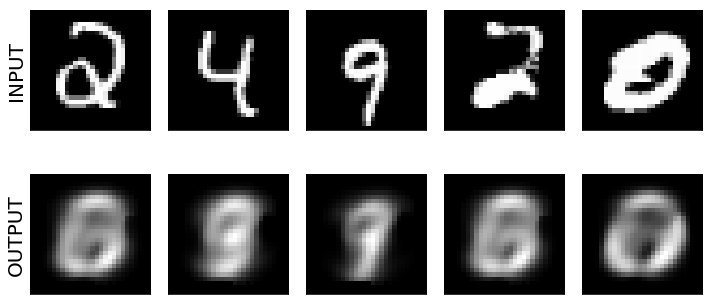

In [12]:
import random
fig, ((ax1, ax2, ax3, ax4, ax5),
      (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(10,5))

# randomly select 5 images
randomly_selected_imgs = random.sample(range(output.shape[0]),5)

# plot original images (input) on top row
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.imshow(X_test[randomly_selected_imgs[i]], cmap='gray')
    if i == 0:
        ax.set_ylabel("INPUT",size=20)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# plot output images from our autoencoder on the bottom row
for i, ax in enumerate([ax6,ax7,ax8,ax9,ax10]):
    ax.imshow(output[randomly_selected_imgs[i]].reshape(28,28), 
              cmap='gray')
    if i == 0:
        ax.set_ylabel("OUTPUT",size=20)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Ok.The output images look terrible!.Its blurry and they look nothing like our original input images. Clearly, an autoencoder with a hidden layer size of one node is insufficient to encode this dataset. This latent representation is too small for our autoencoder to sufficiently capture the salient features of our data.
`Lets use more Hidden layers`.

### Effect of hidden layer size on autoencoder performance

Let's try training autoencoders with different hidden layer sizes and see how they fare.

We will train five different models with 2, 4, 8, 16, and 32 nodes in the hidden layer:

In [13]:
#creating function for basic autoencoder
def create_autoencoder(hidden_layer_size):
    model = Sequential() 
    model.add(Dense(units=hidden_layer_size, input_shape=(784,), 
                    activation='relu'))
    model.add(Dense(units=784, activation='sigmoid'))
    return model


#creating different models with 2,4,8,16,32
for i in range(1,6):
    print(f'hiddenLayerSize_{2**i}_model')
    globals()[f'hiddenLayerSize_{2**i}_model'] = create_autoencoder(hidden_layer_size=2**i)

hiddenLayerSize_2_model
hiddenLayerSize_4_model
hiddenLayerSize_8_model
hiddenLayerSize_16_model
hiddenLayerSize_32_model


In [14]:
#let's train all five of our models together

for i in range(1,6):
    print(f'hiddenLayerSize_{2**i}_model training is getting started...')
    globals()[f'hiddenLayerSize_{2**i}_model'].compile(optimizer='adam',loss='mean_squared_error')
    globals()[f'hiddenLayerSize_{2**i}_model'].fit(X_train_reshaped, X_train_reshaped,epochs=10)


hiddenLayerSize_2_model training is getting started...
Epoch 1/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.0698
Epoch 2/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.0590
Epoch 3/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.0573
Epoch 4/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.0567
Epoch 5/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0563
Epoch 6/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.0561
Epoch 7/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0560
Epoch 8/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.0559
Epoch 9/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.0558
Epoch 10/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0557
hiddenLayerSize_4_model training is getting started...
Epoch 1/10
60000/60

In [15]:
for i in range(1,6):
    print(f'model_{2**i}')
    globals()[f'model_{2**i}'] = globals()[f'hiddenLayerSize_{2**i}_model'].predict(X_test_reshaped)

model_2
model_4
model_8
model_16
model_32


Now, let's plot randomly selected outputs from each model and see how they compare to the original input image

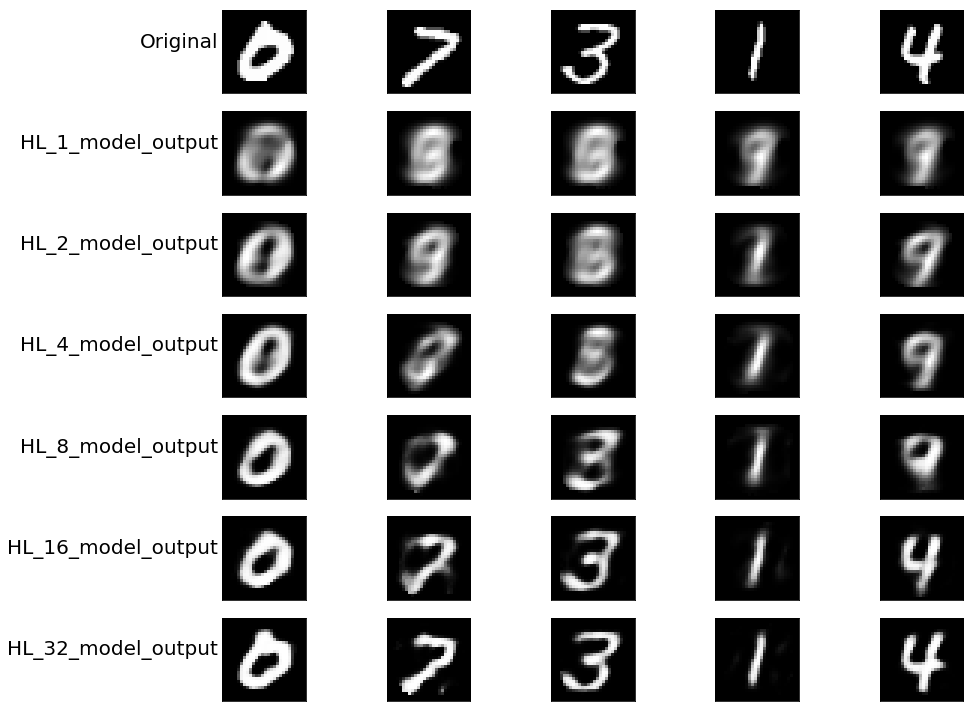

In [16]:
fig, axes = plt.subplots(7, 5, figsize=(15,10))

randomly_selected_imgs = random.sample(range(output.shape[0]),5)
outputs = [X_test, output, model_2, model_4, model_8,
           model_16, model_32]

           
# Iterate through each subplot and plot accordingly
count = 2
sums = 2
for row_num, row in enumerate(axes):
    for col_num, ax in enumerate(row):
        ax.imshow(outputs[row_num][randomly_selected_imgs[col_num]].reshape(28,28), cmap='gray')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if [row_num,col_num] == [0,0]:
            ax.set_ylabel('Original',size=20,rotation="horizontal", ha='right')
        if [row_num,col_num] == [1,0]:
            ax.set_ylabel(f'HL_{1}_model_output',size=20, rotation="horizontal", ha='right')                  
        if [row_num,col_num] == [count,0]:
            ax.set_ylabel(f'HL_{sums}_model_output',size=20, rotation="horizontal", ha='right')
            sums*=2
            count+=1
plt.tight_layout()
plt.show()

Now We can clearly see a nice transition as we double the number of nodes in the hidden layer. Gradually, we see that the output images become clearer and closer to the original input as we increase the number of nodes in the hidden layer.

At 32 nodes in the hidden layer, the output becomes very close (though not perfect) to the original input. But to note, we have shrunk the original input by 24.5 times (784÷32 nodes) and still managed to produce a satisfactory output. That's a pretty impressive compression ratio!

## Building autoencoder for image denoising in Keras

Another interesting application of autoencoders is image denoising. Image noise is defined as a random variations of brightness in an image. Image noise may originate from the sensors of digital cameras. Although digital cameras these days are capable of capturing high quality images, image noise may still occur, especially in low light conditions. 

Early methods include applying some sort of image filter (that is, mean averaging filter, where the pixel value is replaced with the average pixel value of its neighbors) over the image. However, such methods can sometimes fall short and the effects can be less than ideal.

To train autoencoders for image denoising the idea is simple. Instead of using the same input and output when training conventional autoencoders (as described in the previous section), we use a noisy image as the input and a clean reference image for the autoencoder to compare its output against. 

<img src = "/content/noisemnist-autoencoder.png">

During the training process, the autoencoder will learn that the noises in the image should not be part of the output, and will learn to output a clean image. Remember, we are training our autoencoder to remove noise from images!

Let's start by introducing noise to the MNIST dataset. We'll add a random value between -0.5 and 0.5 to each pixel in the original images. This has the effect of increasing and decreasing the intensity of pixels at random.

In [0]:
import numpy as np

X_train_noisy = X_train_reshaped + np.random.normal(0, 0.5,size=X_train_reshaped.shape)
X_test_noisy = X_test_reshaped + np.random.normal(0, 0.5,size=X_test_reshaped.shape)

In [0]:
#using clip from numpy on the noisy images to normalize the images between 0 and 1 

X_train_noisy = np.clip(X_train_noisy, a_min=0, a_max=1)
X_test_noisy = np.clip(X_test_noisy, a_min=0, a_max=1)

Let's define a basic autoencoder just like we did in the previously. This basic autoencoder has a single hidden layer with `16 nodes`.
We will create the autoencoder using the function that we defined before

In [0]:
basic_denoise_autoencoder = create_autoencoder(hidden_layer_size=16)

Next, we train our denoising autoencoder. Remember, the input to the denoising autoencoder is a noisy image and the output is a clean image.

In [20]:
basic_denoise_autoencoder.compile(optimizer='adam',loss='mean_squared_error')
basic_denoise_autoencoder.fit(X_train_noisy, X_train_reshaped, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.0479
Epoch 2/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0312
Epoch 3/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0302
Epoch 4/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0299
Epoch 5/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0297
Epoch 6/10
60000/60000 [==============================] - 7s 125us/step - loss: 0.0296
Epoch 7/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0294
Epoch 8/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0293
Epoch 9/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0292
Epoch 10/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0290


In [0]:
output = basic_denoise_autoencoder.predict(X_test_noisy)

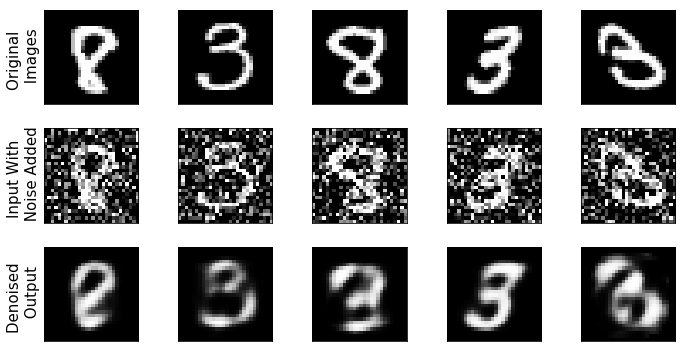

In [22]:
#Lets plot the output and compare it with the original image and the noisy image

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5, figsize=(10,5))
randomly_selected_imgs = random.sample(range(output.shape[0]),5)

# 1st row for original images
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.imshow(X_test_reshaped[randomly_selected_imgs[i]].reshape(28,28), 
              cmap='gray')
    if i == 0:
        ax.set_ylabel("Original \n Images", size=15)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# 2nd row for input with noise added
for i, ax in enumerate([ax6,ax7,ax8,ax9,ax10]):
    ax.imshow(X_test_noisy[randomly_selected_imgs[i]].reshape(28,28),
              cmap='gray')
    if i == 0:
        ax.set_ylabel("Input With \n Noise Added", size=15)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# 3rd row for output images from our autoencoder
for i, ax in enumerate([ax11,ax12,ax13,ax14,ax15]):
    ax.imshow(output[randomly_selected_imgs[i]].reshape(28,28), 
              cmap='gray')
    if i == 0:
        ax.set_ylabel("Denoised \n Output", size=15)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

How does it do? Well, it could definitely be better! This basic denoising autoencoder is perfectly capable of removing noise, but it doesn't do a very good job at reconstructing the original image. We can see that this basic denoising autoencoder sometimes fails to separate noise from the digits.

### Constructing Deep convolutional neural network denoising autoencoder

Can we do better than the basic, one-hidden layer autoencoder that we use previously if you know CNNs perform well for image classification tasks. Naturally, we can apply the same concept for autoencoders too. Instead of using only one hidden layer, we use multiple layers (that is, a deep network) and instead of a fully connected dense layer, we use convolutional layers.

<img src="/content/deepcnn-autoencoder.png">

In [0]:
conv_autoencoder = Sequential()

Next, let's add the first two convolutional layers.There are several parameters we need to define while using the Conv2D class in Keras:

 - Number of filters: Typically, we use a decreasing number of filters for each layer in the encoder. Conversely, we use an increasing number of filters for each layer in the decoder. Let's use 16 filters for the first convolutional layer in the encoder and eight filters for the second convolutional layer in the encoder. Conversely, let's use eight filters for the first convolutional layer in the decoder and 16 filters for the second convolutional layer in the decoder.

 - Filter size: 3 x 3 is typical for convolutional layers.
 
 - Padding: For autoencoders, we use a same padding. This ensures that the height and width of successive layers remains the same. This is useful because we need to ensure that the dimensions of the final output is the same as the input.

In [0]:
 #Adding the first two convolutional layers with the mentioned parameters to our model as encoder

from keras.layers import Conv2D

conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu', padding='same',input_shape=(28,28,1)))
conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3),activation='relu', padding='same'))

Next, we'll add the decoder layers onto our model. Just like the encoder layers, the decoder layers are also convolutional layers.   
The only difference is that, in the decoder layers, we use an increasing number of filters after each successive layer.


In [0]:
#Adding two convolutional layers as the decoder

conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3),activation='relu', padding='same'))
conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3),activation='relu', padding='same'))

Finally, we add the output layer to our model. The output layer should be a convolutional layer with only one filter, as we are trying to output a 28 x 28 x 1 image. The Sigmoid function is used as the activation function for the output layer.

In [0]:
#final output layer
conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3),activation='sigmoid', padding='same'))

In [27]:
#lets check the structure using summary()
conv_autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         1160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [28]:
#Training
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
conv_autoencoder.fit(X_train_noisy.reshape(60000,28,28,1),X_train_reshaped.reshape(60000,28,28,1),epochs=10)

Epoch 1/10
60000/60000 [==============================] - 20s 337us/step - loss: 0.1221
Epoch 2/10
60000/60000 [==============================] - 18s 292us/step - loss: 0.1027
Epoch 3/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.1014
Epoch 4/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.1007
Epoch 5/10
60000/60000 [==============================] - 17s 289us/step - loss: 0.1001
Epoch 6/10
60000/60000 [==============================] - 17s 289us/step - loss: 0.0997
Epoch 7/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.0994
Epoch 8/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.0989
Epoch 9/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.0987
Epoch 10/10
60000/60000 [==============================] - 17s 289us/step - loss: 0.0985


In [0]:
#testing
output = conv_autoencoder.predict(X_test_noisy.reshape(10000,28,28,1))

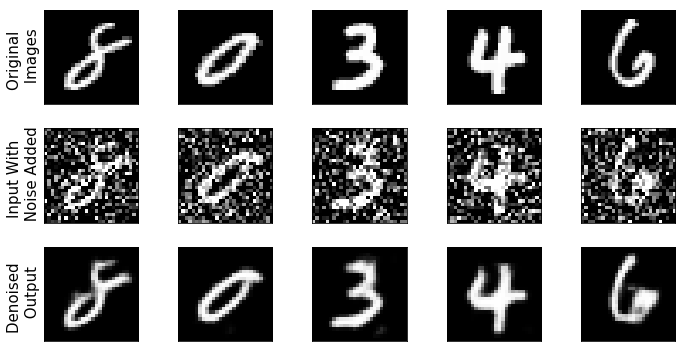

In [32]:
#Lets plot the output and compare it with the original image and the noisy image

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5, figsize=(10,5))
randomly_selected_imgs = random.sample(range(output.shape[0]),5)

# 1st row for original images
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    ax.imshow(X_test_reshaped[randomly_selected_imgs[i]].reshape(28,28), 
              cmap='gray')
    if i == 0:
        ax.set_ylabel("Original \n Images", size=15)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# 2nd row for input with noise added
for i, ax in enumerate([ax6,ax7,ax8,ax9,ax10]):
    ax.imshow(X_test_noisy[randomly_selected_imgs[i]].reshape(28,28), 
              cmap='gray')
    if i == 0:
        ax.set_ylabel("Input With \n Noise Added", size=15)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# 3rd row for output images from our autoencoder
for i, ax in enumerate([ax11,ax12,ax13,ax14,ax15]):
    ax.imshow(output[randomly_selected_imgs[i]].reshape(28,28), 
              cmap='gray')
    if i == 0:
        ax.set_ylabel("Denoised \n Output", size=15)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Isn't that amazing? The denoised output from our deep convolutional autoencoder is so good that we can barely differentiate the original images and the denoised output.

Despite the impressive results, please note that the convolutional model that we used is pretty simple. The advantage of deep neural networks is that we can always increase the complexity of the model (that is, more layers and more filters per layer) and use it on more complex datasets.The ability to scale is one of the main advantages of deep neural networks.

## Denoising documents with autoencoders in Keras

So far, we have applied our denoising autoencoder on the MNIST dataset, which is a pretty simple dataset. Let's take a look now at a more complicated dataset, which better represents the challenges of denoising documents in real life.  
The dataset consists of 216 different noisy images. The noisy images are scanned office documents that are tainted by coffee stains, wrinkled marks, and other sorts of defects that are typical in office documents. For every noisy image, a corresponding reference clean image is provided, which represents the office document in an ideal noiseless state.

In [33]:
!git clone https://github.com/afzal-joy/Autoencoder.git

Cloning into 'Autoencoder'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 274 (delta 0), reused 274 (delta 0), pack-reused 0
Receiving objects: 100% (274/274), 53.31 MiB | 38.01 MiB/s, done.


In [0]:
clean_imgs = 'Autoencoder/Original'
noisy_imgs = 'Autoencoder/Coffe staine Noise'

In [0]:
#will use load_img function to load images. and then we will use img_to_array function to convert into numpy arrays.
import os
from keras.preprocessing.image import load_img, img_to_array

X_train_clean = []

for file in sorted(os.listdir(clean_imgs)):
    img = load_img(clean_imgs+"/"+file, color_mode='grayscale', 
                   target_size=(420,540))
    img = img_to_array(img).astype('float32')/255
    X_train_clean.append(img) 

# convert to numpy array
X_train_clean = np.array(X_train_clean)


X_train_noisy = []

for file in sorted(os.listdir(noisy_imgs)):
    img = load_img(noisy_imgs+"/"+file, color_mode='grayscale', 
                   target_size=(420,540))
    img = img_to_array(img).astype('float32')/255
    X_train_noisy.append(img)

# convert to numpy array
X_train_noisy = np.array(X_train_noisy)

Let's display the loaded images to have a better idea of the kind of images we are dealing with

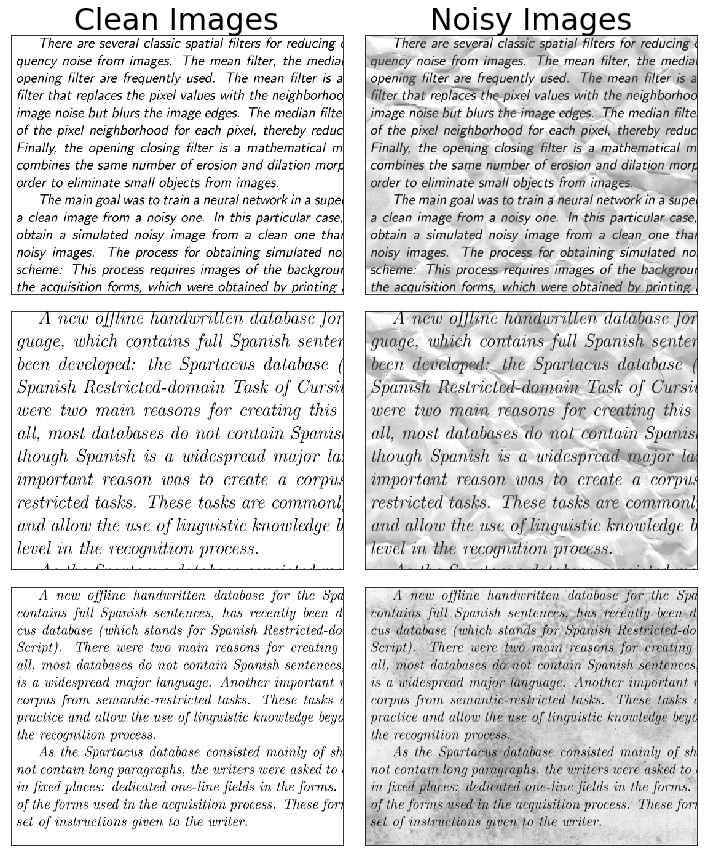

In [36]:
import random
fig, ((ax1,ax2), (ax3,ax4), 
      (ax5,ax6)) = plt.subplots(3, 2, figsize=(10,12))

randomly_selected_imgs = random.sample(range(X_train_noisy.shape[0]),3)


for i, ax in enumerate([ax1,ax3,ax5]):
    ax.imshow(X_train_clean[i].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Clean Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])


for i, ax in enumerate([ax2,ax4,ax6]):
    ax.imshow(X_train_noisy[i].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Noisy Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

We can see that the kind of noise in this dataset is markedly different from what we saw in the MNIST dataset. The noise in this dataset are random artifacts that appear throughout the image. Our autoencoder model needs to have a strong understanding of signal versus noise in order to successfully denoise this dataset

In [0]:
#Train and Test split

X_test_clean = X_train_clean[0:20,]
X_train_clean = X_train_clean[21:,]

X_test_noisy = X_train_noisy[0:20,]
X_train_noisy = X_train_noisy[21:,]

### Basic convolutional autoencoder

In [0]:
basic_conv_autoencoder = Sequential()

In [0]:
#we add a single convolutional layer as our encoder layer
basic_conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3),
                                  activation='relu', padding='same', 
                                  input_shape=(420,540,1)))

In [0]:
#we add a single convolutional layer as our decoder layer
basic_conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), 
                                  activation='relu', padding='same'))

In [0]:
#Finally, we add an output layer
basic_conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), 
                                  activation='sigmoid', padding='same'))

In [42]:
basic_conv_autoencoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 420, 540, 8)       80        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 420, 540, 8)       584       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 420, 540, 1)       73        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [43]:
#compiling and training
basic_conv_autoencoder.compile(optimizer='adam', 
                               loss='binary_crossentropy')
basic_conv_autoencoder.fit(X_train_noisy, X_train_clean, epochs=10)

Epoch 1/10
195/195 [==============================] - 5s 23ms/step - loss: 0.7165
Epoch 2/10
195/195 [==============================] - 2s 9ms/step - loss: 0.5981
Epoch 3/10
195/195 [==============================] - 2s 9ms/step - loss: 0.4773
Epoch 4/10
195/195 [==============================] - 2s 9ms/step - loss: 0.3728
Epoch 5/10
195/195 [==============================] - 2s 9ms/step - loss: 0.3035
Epoch 6/10
195/195 [==============================] - 2s 9ms/step - loss: 0.2719
Epoch 7/10
195/195 [==============================] - 2s 9ms/step - loss: 0.2545
Epoch 8/10
195/195 [==============================] - 2s 9ms/step - loss: 0.2405
Epoch 9/10
195/195 [==============================] - 2s 9ms/step - loss: 0.2281
Epoch 10/10
195/195 [==============================] - 2s 9ms/step - loss: 0.2122


In [0]:
#Testing
output = basic_conv_autoencoder.predict(X_test_noisy)

Let's plot the output and see what kind of results we got. The following code plots the original noisy images in the left column, the original clean images in the middle column, and the denoised image output from our model in the right column

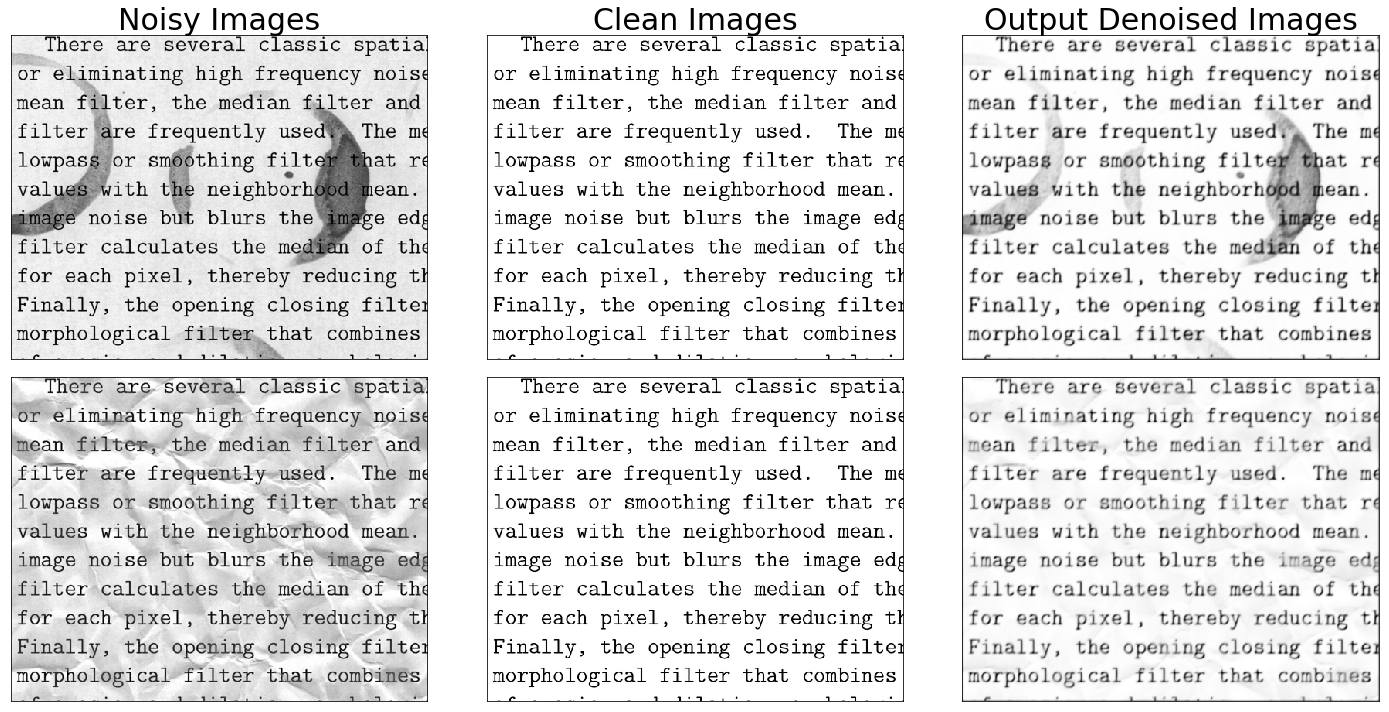

In [45]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,10))

randomly_selected_imgs = random.sample(range(X_test_noisy.shape[0]),2)

for i, ax in enumerate([ax1, ax4]):
    idx = randomly_selected_imgs[i]
    ax.imshow(X_test_noisy[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Noisy Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate([ax2, ax5]):
    idx = randomly_selected_imgs[i]
    ax.imshow(X_test_clean[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Clean Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate([ax3, ax6]):
    idx = randomly_selected_imgs[i]
    ax.imshow(output[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Output Denoised Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Well, our model can certainly do a better job. The denoised images tend to have a gray background rather than a white background in the true Clean Images. The model also does a poor job at removing the coffee stains from the Noisy Images. Furthermore, the words in the denoised images are faint, showing that the model struggles at this task.

### Deep convolutional autoencoder
Let's try denoising the images with a deeper model and more filters in each convolutional layer

In [0]:
conv_autoencoder = Sequential()

In [0]:
#three convolutional layers as our encoder, with 32, 16, and 8 filters
conv_autoencoder.add(Conv2D(filters=32, kernel_size=(3,3),
                            input_shape=(420,540,1), 
                            activation='relu', padding='same'))
conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3),
                            activation='relu', padding='same'))
conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3),
                            activation='relu', padding='same'))

In [0]:
#we add three convolutional layers with 8, 16, and 32 filters as decoder
conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), 
                            activation='relu', padding='same'))
conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), 
                            activation='relu', padding='same'))
conv_autoencoder.add(Conv2D(filters=32, kernel_size=(3,3), 
                            activation='relu', padding='same'))

In [0]:
#output
conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), 
                            activation='sigmoid', padding='same'))

In [50]:
conv_autoencoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 420, 540, 32)      320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 420, 540, 16)      4624      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 420, 540, 8)       1160      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 420, 540, 8)       584       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 420, 540, 16)      1168      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 420, 540, 32)      4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 420, 540, 1)     

In [51]:
#compilie and train
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
conv_autoencoder.fit(X_train_noisy, X_train_clean, epochs=10)

Epoch 1/10
195/195 [==============================] - 17s 85ms/step - loss: 0.5264
Epoch 2/10
195/195 [==============================] - 7s 38ms/step - loss: 0.3321
Epoch 3/10
195/195 [==============================] - 7s 38ms/step - loss: 0.3041
Epoch 4/10
195/195 [==============================] - 7s 38ms/step - loss: 0.2937
Epoch 5/10
195/195 [==============================] - 7s 38ms/step - loss: 0.2703
Epoch 6/10
195/195 [==============================] - 8s 39ms/step - loss: 0.2389
Epoch 7/10
195/195 [==============================] - 8s 39ms/step - loss: 0.1968
Epoch 8/10
195/195 [==============================] - 8s 39ms/step - loss: 0.1599
Epoch 9/10
195/195 [==============================] - 8s 39ms/step - loss: 0.1443
Epoch 10/10
195/195 [==============================] - 8s 39ms/step - loss: 0.1307


In [0]:
#Test
output = conv_autoencoder.predict(X_test_noisy)

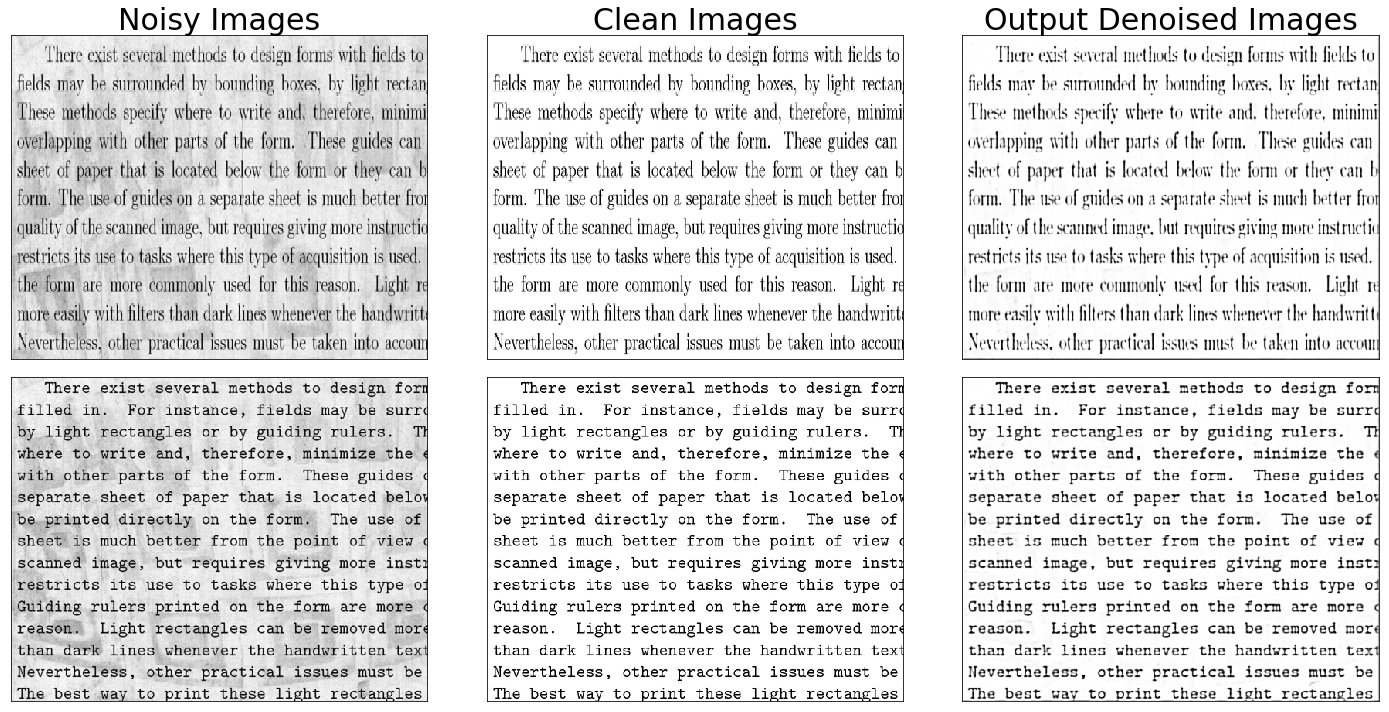

In [53]:
#plotting the output to see the results we got

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,10))

randomly_selected_imgs = random.sample(range(X_test_noisy.shape[0]),2)

for i, ax in enumerate([ax1, ax4]):
    idx = randomly_selected_imgs[i]
    ax.imshow(X_test_noisy[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Noisy Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate([ax2, ax5]):
    idx = randomly_selected_imgs[i]
    ax.imshow(X_test_clean[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Clean Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate([ax3, ax6]):
    idx = randomly_selected_imgs[i]
    ax.imshow(output[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Output Denoised Images", size=30)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

The result looks amazing! In fact, the output denoised images look so good that we can barely differentiate them from the true clean images. We can see that the coffee stain has been almost entirely removed and we can easily read the words in the denoised images.

This dataset truly demonstrates the power of autoencoders. By adding on additional complexity in the form of deeper convolutional layers and more filters, the model is able to differentiate the signal from the noise, allowing it to successfully denoise images that are heavily corrupted.

###Summary

We have seen that autoencoders,learns a latent representation of the input. In short Autoencoders have an `encoder` component that compresses the input into a `latent representation`, and a `decoder` component that reconstructs the input using the `latent representation`.

We trained an autoencoder to compress MNIST images. We showed that by using a hidden layer size of 32 × 1, and we achieved a compression rate of 24.5, while ensuring that the reproduced images were similar to the original input images.

We also looked at using autoencoders for `image denoising`. By using a noisy image as the input and a clean image as the output, we can train an autoencoder to identify features of the image that do not belong to noise, such autoencoders are known as denoising autoencoders. We trained and applied a denoising autoencoder to the office documents, which consists of scanned images of dirty office documents. Using deep convolutional layers within the denoising autoencoder, we managed to remove noise almost entirely from the documents.